### PRoject objectives

- An API driven recommendation system that can be actedupon incongruently(dynamically) 
- pretrain the data using a sample data - <<<<< 
- sample dataset from kaggle.io


Params definition
- AGE: Customer's age
- GENDER: Customer's gender (0: Male, 1: Female)
- Annual Income: Annual income of the customer in dollars
- NUMBER OF PURCHASES: Total number of purchases made by the customer
- PRODUCT CATEGORY: Category of the purchased product (0: Electronics, 1: Clothing, 2: Home Goods, 3: Beauty, 4: Sports)
- Time Spent on Website: Time spent by the customer on the website in minutes
- Loyalty Program: Whether the customer is a member of the loyalty program (0: No, 1: Yes)
- Discounts Availed: Number of discounts availed by the customer (range: 0-5)
- PURCHASE STATUS (Target Variable): Likelihood of the customer making a purchase (0: No, 1: Yes)

PROBLEM STATEMENT
Recommend a product to a customer depending on his age or/gender..

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# we are usnig the customer_purchase dataset

data = pd.read_csv('customer_purchase_data.csv')
data = data[['Age', 'Gender', 'NumberOfPurchases', 'ProductCategory', 'PurchaseStatus']]


data.head()

Age  Gender  NumberOfPurchases  ProductCategory  PurchaseStatus
0   40       1                  8                0               1
1   20       1                  4                2               0
2   27       1                 11                2               1
3   24       1                 19                3               1
4   31       1                 19                1               1

**Checking Up on our target**

In [3]:
data.ProductCategory.value_counts()

ProductCategory
1    331
4    321
0    289
3    286
2    273
Name: count, dtype: int64

**The differnt catagories seem to be reprisented farly**

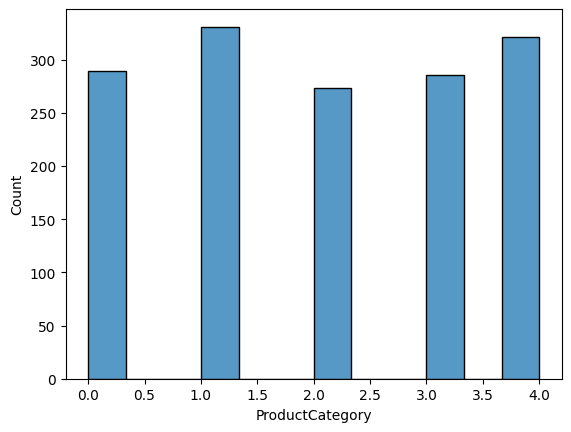

In [4]:
sb.histplot(data.ProductCategory);

**What about a correlation heatMAp of training features with the target**

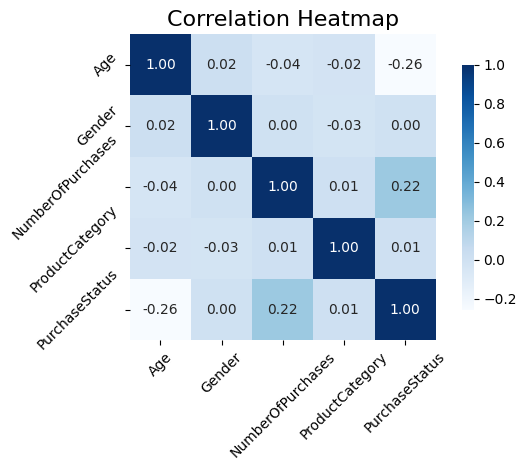

In [5]:
# Create the heatmap
sb.heatmap(data.corr(), cmap="Blues", annot=True, fmt=".2f", square=True, cbar_kws={"shrink": .8})

# Add titles and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

### Feature Engineering

`AgeGroup` Feature

In [6]:
# Define bins and labels
bins = [0, 18, 24, 34, 44, 54, 64, 100]  # 8 edges
labels = ['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']  # 7 labels

# Create the AgeGroup feature
data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

In [7]:
data['AgeGroup'].value_counts()

AgeGroup
45-54    295
35-44    281
25-34    255
55-64    253
65+      231
18-24    185
0-17       0
Name: count, dtype: int64

**No observation in the age range `0-17` we can remove them seems they are not activly making purchase**

In [8]:
# Strip any whitespace from the AgeGroup labels (if any)
data['AgeGroup'] = data['AgeGroup'].str.strip()

# Filter out the '0-17' age group
data = data[data['AgeGroup'] != '0-17']
data['AgeGroup'].value_counts()

AgeGroup
45-54    295
35-44    281
25-34    255
55-64    253
65+      231
18-24    185
Name: count, dtype: int64

In [9]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the AgeGroup column
data['AgeGroupEncoded'] = label_encoder.fit_transform(data['AgeGroup'])

`AvgPurchasesByAgeGroup` Feature

In [10]:
data['AvgPurchasesByAgeGroup'] = data.groupby('AgeGroup')['NumberOfPurchases'].transform('mean')

In [11]:
data['AvgPurchasesByAgeGroup'].describe()

count    1500.000000
mean       10.420000
std         0.281907
min         9.883117
25%        10.276680
50%        10.447458
75%        10.562162
max        10.807829
Name: AvgPurchasesByAgeGroup, dtype: float64

In [12]:
data['AvgPurchasesByAgeGroup'] = data['AvgPurchasesByAgeGroup'] - 9

**HeatMAp after Feature Engineering**

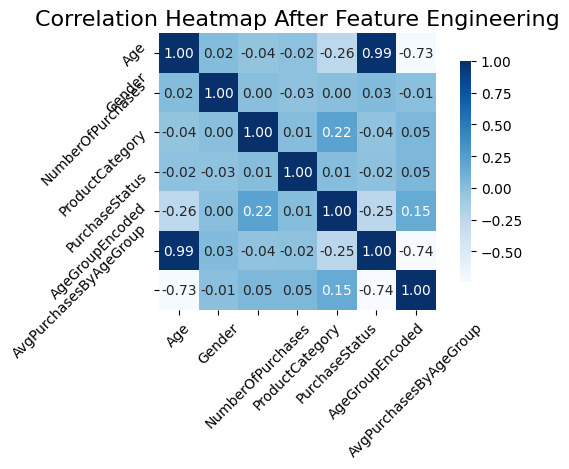

In [13]:
# Create the heatmap
sb.heatmap(data.drop(columns = "AgeGroup").corr(), cmap="Blues", annot=True, fmt=".2f", square=True, cbar_kws={"shrink": .8})

# Add titles and labels
plt.title('Correlation Heatmap After Feature Engineering', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

**Making Visuals**

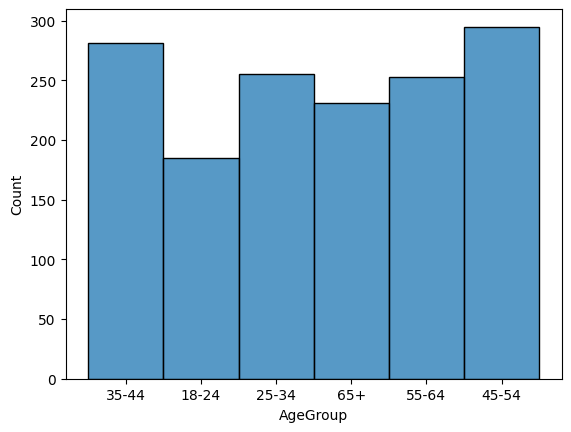

In [14]:
sb.histplot(data['AgeGroup']);

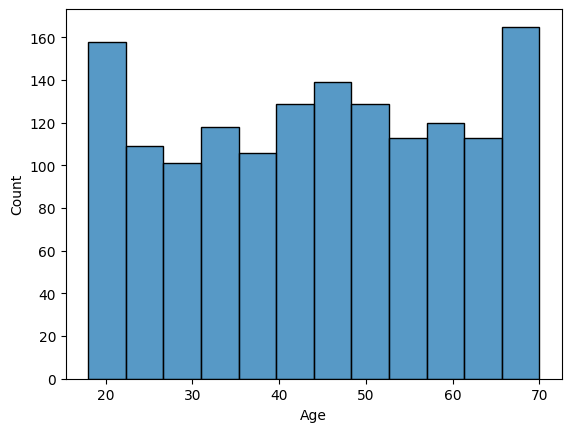

In [15]:
sb.histplot(data['Age']);

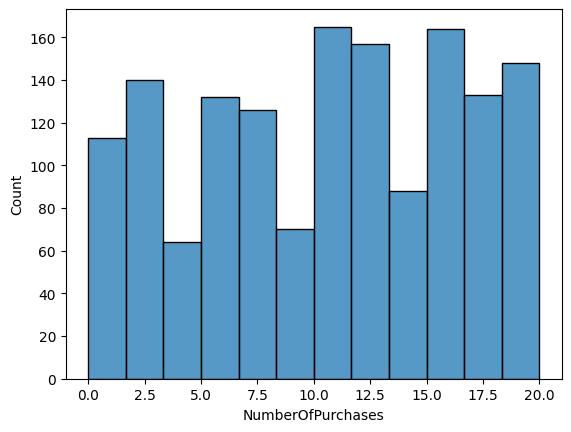

In [16]:
sb.histplot(data['NumberOfPurchases']);

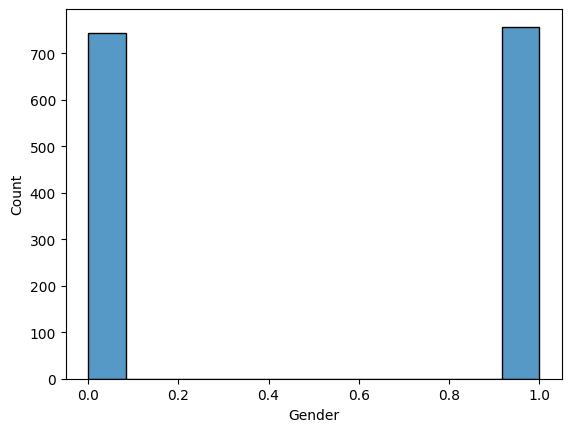

In [17]:
sb.histplot(data['Gender']);

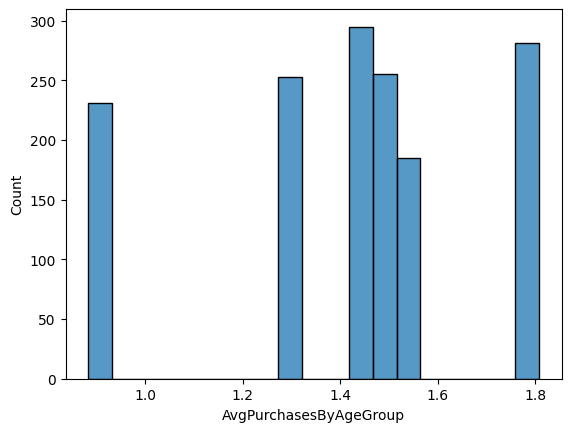

In [18]:
sb.histplot(data['AvgPurchasesByAgeGroup']);

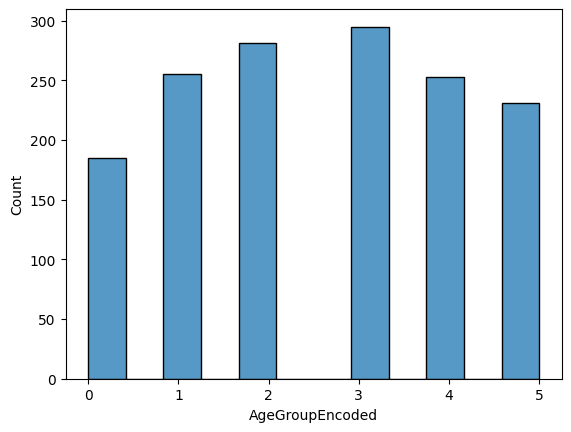

In [19]:
sb.histplot(data['AgeGroupEncoded']);

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     1500 non-null   int64  
 1   Gender                  1500 non-null   int64  
 2   NumberOfPurchases       1500 non-null   int64  
 3   ProductCategory         1500 non-null   int64  
 4   PurchaseStatus          1500 non-null   int64  
 5   AgeGroup                1500 non-null   object 
 6   AgeGroupEncoded         1500 non-null   int64  
 7   AvgPurchasesByAgeGroup  1500 non-null   float64
dtypes: float64(1), int64(6), object(1)
memory usage: 93.9+ KB


## Model Bulding

In [21]:
# X and y
X = data.drop(["ProductCategory","AgeGroup", "AvgPurchasesByAgeGroup"], axis=1)
y = data["ProductCategory"]

In [22]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [23]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**XGBOOST**

In [24]:
xgb_params = {'n_estimators': 1000, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7, 'colsample_bytree': 1.0, 'gamma': 0, 'lambda': 1, 'alpha': 0}

In [25]:
model = XGBClassifier(**xgb_params)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)


y_prediction = model.predict(X_test)
#y_prediction = catboost_model.predict(X_test_poly)
acc = accuracy_score(y_test, y_prediction)

acc

0.2833333333333333

**More thorough approach to getting our models `True` accuracy score**

In [26]:
model_xgb = XGBClassifier(**xgb_params)

# Perform cross-validation
cv_scores = cross_val_score(model_xgb, X, y, cv=cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores for XGB:", cv_scores)
print("Mean cross-validation score for XGB:", cv_scores.mean())

Cross-validation scores for XGB: [0.26333333 0.2        0.26333333 0.25666667 0.25333333]
Mean cross-validation score for XGB: 0.24733333333333332


**RandomForest**

In [27]:
rf_params = {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'}
model_rf = RandomForestClassifier(**rf_params)

# Perform cross-validation
cv_scores = cross_val_score(model_rf, X, y, cv=cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores for RF:", cv_scores)
print("Mean cross-validation score for RF:", cv_scores.mean())

Cross-validation scores for RF: [0.24666667 0.25       0.24       0.25333333 0.23333333]
Mean cross-validation score for RF: 0.24466666666666667


In [28]:
cat_params = {'iterations': 500, 'learning_rate': 0.2, 'depth': 10, 'l2_leaf_reg': 5, 'colsample_bylevel': 0.7, 'bagging_temperature': 1, 'border_count': 128, 'eval_metric': 'AUC'}
model_cat = CatBoostClassifier(**cat_params, verbose=0)

# Perform cross-validation
cv_scores = cross_val_score(model_cat, X, y, cv=cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores For CatBoost:", cv_scores, )
print("Mean cross-validation score For CatBoost:", cv_scores.mean())

Cross-validation scores For CatBoost: [0.29       0.26666667 0.25       0.29333333 0.28333333]
Mean cross-validation score For CatBoost: 0.27666666666666667


In [29]:
# Fit the model to extract feature importance
model_xgb.fit(X, y)
importance_xgb = model_xgb.feature_importances_

# Create a DataFrame for XGBoost feature importance
importance_xgb_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance_xgb
}).sort_values(by='Importance', ascending=False)

importance_xgb_df

Feature  Importance
0                Age    0.259753
3     PurchaseStatus    0.257778
2  NumberOfPurchases    0.244707
1             Gender    0.237762
4    AgeGroupEncoded    0.000000

In [30]:
# Fit the model to extract feature importance
model_rf.fit(X, y)
importance_rf = model_rf.feature_importances_

# Create a DataFrame for Random Forest feature importance
importance_rf_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance_rf
}).sort_values(by='Importance', ascending=False)

importance_rf_df

Feature  Importance
0                Age    0.436656
2  NumberOfPurchases    0.376306
4    AgeGroupEncoded    0.089758
3     PurchaseStatus    0.063162
1             Gender    0.034118

In [31]:
# Fit the model to extract feature importance
model_cat.fit(X, y)
importance_cat = model_cat.get_feature_importance()

# Create a DataFrame for CatBoost feature importance
importance_cat_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance_cat
}).sort_values(by='Importance', ascending=False)

importance_cat_df

Feature  Importance
2  NumberOfPurchases   30.815135
0                Age   26.392163
1             Gender   18.229841
3     PurchaseStatus   16.572153
4    AgeGroupEncoded    7.990708

### Classifiaction reports for each models

In [32]:
# Define target names
target_names = ['Category 0', 'Category 1', 'Category 2', 'Category 3', 'Category 4']

def fit_models(X_train, y_train):
    # Define model parameters
    xgb_params = {
        'n_estimators': 1000,
        'learning_rate': 0.1,
        'max_depth': 3,
        'min_child_weight': 3,
        'subsample': 0.7,
        'colsample_bytree': 1.0,
        'gamma': 0,
        'lambda': 1,
        'alpha': 0
    }
    model_xgb = XGBClassifier(**xgb_params)

    rf_params = {
        'n_estimators': 100,
        'max_depth': 20,
        'min_samples_split': 5,
        'min_samples_leaf': 4,
        'max_features': 'log2',
        'bootstrap': False,
        'criterion': 'gini'
    }
    model_rf = RandomForestClassifier(**rf_params)

    cat_params = {
        'iterations': 500,
        'learning_rate': 0.2,
        'depth': 10,
        'l2_leaf_reg': 5,
        'colsample_bylevel': 0.7,
        'bagging_temperature': 1,
        'border_count': 128,
        'eval_metric': 'AUC'
    }
    model_cat = CatBoostClassifier(**cat_params, verbose=0)

    # Fit the models
    model_xgb.fit(X_train, y_train)
    model_rf.fit(X_train, y_train)
    model_cat.fit(X_train, y_train)

    return model_xgb, model_rf, model_cat

# Example usage:
model_xgb, model_rf, model_cat = fit_models(X_train, y_train)

# Make predictions
y_pred_xgb = model_xgb.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_catboost = model_cat.predict(X_test)

# Generate classification reports
report_xgb = classification_report(y_test, y_pred_xgb, target_names=target_names)
report_rf = classification_report(y_test, y_pred_rf, target_names=target_names)
report_catboost = classification_report(y_test, y_pred_catboost, target_names=target_names)

# Print the reports
print("XGBoost Classification Report:\n", report_xgb)
print("Random Forest Classification Report:\n", report_rf)
print("CatBoost Classification Report:\n", report_catboost)

XGBoost Classification Report:
               precision    recall  f1-score   support

  Category 0       0.31      0.25      0.28        67
  Category 1       0.29      0.31      0.30        64
  Category 2       0.25      0.30      0.27        54
  Category 3       0.33      0.32      0.32        53
  Category 4       0.25      0.24      0.25        62

    accuracy                           0.28       300
   macro avg       0.29      0.29      0.28       300
weighted avg       0.29      0.28      0.28       300

Random Forest Classification Report:
               precision    recall  f1-score   support

  Category 0       0.27      0.21      0.24        67
  Category 1       0.27      0.30      0.28        64
  Category 2       0.27      0.28      0.27        54
  Category 3       0.34      0.40      0.37        53
  Category 4       0.26      0.26      0.26        62

    accuracy                           0.28       300
   macro avg       0.28      0.29      0.28       300
weighte

# Summary of Classification Reports

## XGBoost Classification Report
- **Accuracy**: 28%
- **Macro Average**:
  - **Precision**: 0.29
  - **Recall**: 0.29
  - **F1-Score**: 0.28
- **Weighted Average**:
  - **Precision**: 0.29
  - **Recall**: 0.28
  - **F1-Score**: 0.28
- **Category Performance**:
  - **Category 0**: Precision 0.31, Recall 0.25, F1-Score 0.28
  - **Category 1**: Precision 0.29, Recall 0.31, F1-Score 0.30
  - **Category 2**: Precision 0.25, Recall 0.30, F1-Score 0.27
  - **Category 3**: Precision 0.33, Recall 0.32, F1-Score 0.32
  - **Category 4**: Precision 0.25, Recall 0.24, F1-Score 0.25

## Random Forest Classification Report
- **Accuracy**: 28%
- **Macro Average**:
  - **Precision**: 0.28
  - **Recall**: 0.28
  - **F1-Score**: 0.28
- **Weighted Average**:
  - **Precision**: 0.28
  - **Recall**: 0.28
  - **F1-Score**: 0.28
- **Category Performance**:
  - **Category 0**: Precision 0.27, Recall 0.21, F1-Score 0.24
  - **Category 1**: Precision 0.29, Recall 0.34, F1-Score 0.31
  - **Category 2**: Precision 0.23, Recall 0.22, F1-Score 0.23
  - **Category 3**: Precision 0.31, Recall 0.36, F1-Score 0.33
  - **Category 4**: Precision 0.29, Recall 0.27, F1-Score 0.28

## CatBoost Classification Report
- **Accuracy**: 29%
- **Macro Average**:
  - **Precision**: 0.29
  - **Recall**: 0.29
  - **F1-Score**: 0.29
- **Weighted Average**:
  - **Precision**: 0.29
  - **Recall**: 0.29
  - **F1-Score**: 0.29
- **Category Performance**:
  - **Category 0**: Precision 0.32, Recall 0.31, F1-Score 0.32
  - **Category 1**: Precision 0.29, Recall 0.27, F1-Score 0.28
  - **Category 2**: Precision 0.28, Recall 0.30, F1-Score 0.29
  - **Category 3**: Precision 0.30, Recall 0.34, F1-Score 0.32
  - **Category 4**: Precision 0.25, Recall 0.23, F1-Score 0.24

## Observations
- All models show similar accuracy levels, hovering around 28-29%.
- **XGBoost** has the highest precision for Category 0, while **CatBoost** performs slightly better overall in terms of F1-Score.
- **Random Forest** struggles with lower precision and recall across most categories, particularly for Category 0.
- The models exhibit a challenge in classifying the categories effectively, as indicated by the low F1-scores.

# Comprehensive Summary of Findings

In our analysis, we evaluated three different machine learning models—**XGBoost**, **Random Forest**, and **CatBoost**—to predict a target variable based on several features. We reassessed each model's performance using cross-validation and examined the importance of each feature in making predictions.

## Feature Importance

### XGBoost Feature Importance
The top features identified by the XGBoost model were:
| Feature                     | Importance |
|-----------------------------|------------|
| Age                         | 0.2598     |
| PurchaseStatus              | 0.2578     |
| NumberOfPurchases          | 0.2447     |
| Gender                      | 0.2378     |
| AgeGroupEncoded             | 0.0000     |

**Key Insight**: The feature **PurchaseStatus** has emerged as a significant predictor alongside **Age** and **NumberOfPurchases**. The encoded age group feature remains non-influential.

### Random Forest Feature Importance
The Random Forest model highlighted the following features:
| Feature                     | Importance |
|-----------------------------|------------|
| Age                         | 0.4394     |
| NumberOfPurchases          | 0.3639     |
| PurchaseStatus              | 0.0656     |
| AgeGroupEncoded             | 0.0474     |
| Gender                      | 0.0362     |

**Key Insight**: **Age** and **NumberOfPurchases** continue to be the most critical features, with **PurchaseStatus** also contributing to the model's predictions.

### CatBoost Feature Importance
The CatBoost model ranked the features as follows:
| Feature                     | Importance |
|-----------------------------|------------|
| NumberOfPurchases          | 30.8151    |
| Age                         | 26.3922    |
| Gender                      | 18.2298    |
| PurchaseStatus              | 16.5722    |
| AgeGroupEncoded             | 7.9907     |

**Key Insight**: **NumberOfPurchases** remains the most significant feature, with **PurchaseStatus** also playing a notable role in predictions.

## Model Performance

The performance of each model was evaluated using 5-fold cross-validation, and the mean cross-validation scores were as follows:

- **XGBoost**:
  - Cross-validation scores: [0.2633, 0.2000, 0.2633, 0.2567, 0.2533]
  - **Mean Score**: 0.2473

- **Random Forest**:
  - Cross-validation scores: [0.2467, 0.2433, 0.2533, 0.2600, 0.2467]
  - **Mean Score**: 0.2500

- **CatBoost**:
  - Cross-validation scores: [0.2900, 0.2667, 0.2500, 0.2933, 0.2833]
  - **Mean Score**: 0.2767

## Conclusion

- **Best Performing Model**: The **CatBoost** model achieved the highest mean cross-validation score of **0.2767**, indicating it performed better than both XGBoost and Random Forest in this analysis.
- **Feature Importance Insights**: **PurchaseStatus** has shown to enhance the predictive capabilities of the models, particularly in XGBoost and CatBoost. **Age** and **NumberOfPurchases** remain essential features, while the **AgeGroupEncoded** feature continues to show minimal influence.

This comprehensive analysis highlights the strengths of each model and provides insights into the features that drive predictions, which can be valuable for further model refinement and decision-making.

# Important Note

**Overall, the use of tree-based models for this problem resulted in relatively low accuracy scores.**

The mean cross-validation scores for the models were as follows:

- **XGBoost**: 0.2473
- **Random Forest**: 0.2500
- **CatBoost**: 0.2767

While tree-based methods offer advantages such as interpretability and the capability to manage non-linear relationships, the results suggest that these models did not achieve optimal performance for this specific dataset/task. This indicates that further exploration of alternative modeling approaches or feature engineering may be necessary to improve predictive accuracy.

## !!!Drilling Down on our best model CatBoost predictive Capability

In [33]:
cat_params = {'iterations': 500, 'learning_rate': 0.2, 'depth': 10, 'l2_leaf_reg': 5, 'colsample_bylevel': 0.7, 'bagging_temperature': 1, 'border_count': 128, 'eval_metric': 'AUC'}
model_cat = CatBoostClassifier(**cat_params, verbose=0)
model_cat.fit(X_train, y_train)

# Make probability predictions on the test set
probabilities = model_cat.predict_proba(X_test)

# Create a DataFrame with the probabilities
probability_df = pd.DataFrame(probabilities, columns=[0, 1, 2, 3, 4])

# Display the DataFrame
probability_df.head()

0         1         2         3         4
0  0.104204  0.027365  0.065990  0.700339  0.102102
1  0.294122  0.007984  0.051022  0.600904  0.045968
2  0.285659  0.289899  0.169010  0.191857  0.063575
3  0.184729  0.047368  0.560475  0.120630  0.086798
4  0.100573  0.018861  0.138871  0.455378  0.286317

In [34]:
# Reset index for y_test
y_test_reset = y_test.reset_index(drop=True)

probability_df["predictions"] = y_pred_catboost
probability_df["Actual_class"] = y_test_reset

probability_df.head()

0         1         2         3         4  predictions  Actual_class
0  0.104204  0.027365  0.065990  0.700339  0.102102            3             3
1  0.294122  0.007984  0.051022  0.600904  0.045968            3             0
2  0.285659  0.289899  0.169010  0.191857  0.063575            1             1
3  0.184729  0.047368  0.560475  0.120630  0.086798            2             2
4  0.100573  0.018861  0.138871  0.455378  0.286317            3             4

In [35]:
probability_df[probability_df["predictions"] != probability_df["Actual_class"]]

0         1         2         3         4  predictions  \
1    0.294122  0.007984  0.051022  0.600904  0.045968            3   
4    0.100573  0.018861  0.138871  0.455378  0.286317            3   
6    0.011234  0.101050  0.612573  0.196295  0.078847            2   
8    0.873952  0.087493  0.001509  0.006224  0.030822            0   
9    0.012970  0.199797  0.230975  0.185169  0.371090            4   
..        ...       ...       ...       ...       ...          ...   
289  0.175204  0.146494  0.104866  0.312458  0.260977            3   
290  0.008076  0.256371  0.669558  0.051343  0.014653            2   
291  0.240276  0.246931  0.333728  0.071592  0.107473            2   
292  0.760877  0.023793  0.197733  0.006602  0.010995            0   
298  0.009472  0.150458  0.277742  0.511344  0.050984            3   

     Actual_class  
1               0  
4               4  
6               0  
8               4  
9               1  
..            ...  
289             4  
290             4  
291             0  
292             3  
298             2  

[214 rows x 7 columns]

In [36]:
sum(probability_df["predictions"] == probability_df["Actual_class"])/len(probability_df)

0.2866666666666667

### !! Even If we make two recommendation out of the given `5` `ProductCategorys` we still be off that's alarming